### Made by Liang Yihuai, 2019/12/02

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import sys

from matplotlib import pyplot as plt

from sklearn.model_selection import cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

%load_ext autoreload
%autoreload 2

%reload_ext autoreload
%matplotlib inline

In [2]:
data_path = 'images/faces94/'

In [3]:
WIDTH = 200
HEIGHT = 180

def get_train_test_image_path(path, imageType='.jpg'):
    train_paths = []  #
    test_paths = []

    person_names = os.listdir(path)  # each person's images in a folder
    all_image_names = []
    for person_name in person_names:
        sub_path = path + person_name + "/";
        one_person_image_names = os.listdir(sub_path)
        one_person_image_names = [sub_path + i for i in one_person_image_names if i.endswith(imageType)]
        if len(one_person_image_names) > 3:
            train_paths += one_person_image_names[:-2]
            test_paths += one_person_image_names[-2:]  # use the last two images of each person as test data

    return np.array(train_paths), np.array(test_paths)

In [4]:
train_paths, test_paths = get_train_test_image_path(data_path)
print(train_paths.shape)

(2753,)


In [5]:
def get_images(paths):
    images  = []
    labels = []
    # read image
    for path in paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        images.append(img)
        labels.append(path.rsplit('/', 1)[-1].split('.', 1)[0])
    images = np.array(images)
    images = images.reshape((images.shape[0], WIDTH * HEIGHT))
    return np.array(images), np.array(labels)

In [6]:
x_train, y_train = get_images(train_paths)
x_test, y_test = get_images(test_paths)

In [7]:
NOBODY = '0'

# whether 'dataset' contains 'a_data'
def contains(dataset, a_data):
    for v in dataset:
        if v == a_data:
            return True;
    return False

# the people in the test data but not in the training set are 'nobody'.
# mark people who is nobody for test data
for i in range(len(y_test)):
    if not contains(y_train, y_test[i]):
        y_test[i] = NOBODY

In [55]:
print(x_test.shape, y_test.shape)

(306, 36000) (306,)


In [8]:
np.unique(y_train).size

152

In [9]:
np.unique(y_test).size

152

In [10]:
unique_train_labels = np.unique(y_train)
np.random.seed(1)
labels_to_abandom = np.random.choice(unique_train_labels, 38)

mask = np.ones((len(y_train), ), dtype='uint8')
for i in range(len(y_train)):
    for label in labels_to_abandom:
        if y_train[i] == label:
            mask[i] = 0
            break

In [11]:
print(unique_train_labels.size, labels_to_abandom.size)

152 38


In [12]:
x_train = x_train[mask==1]
y_train = y_train[mask==1]

In [13]:
print(x_train.shape, y_train.shape, np.unique(y_train).size)

(2120, 36000) (2120,) 117


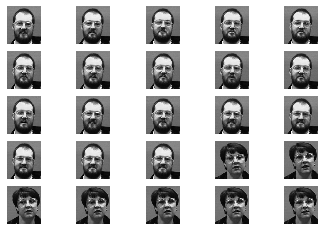

In [14]:
# training faces after minus mean face.
for i in range(25):
    plt.subplot(5, 5, i+1) # row / col / index + 1
    plt.imshow(x_train[i].reshape(WIDTH, HEIGHT), cmap=plt.cm.gray)
    plt.axis('off')
plt.show()

In [15]:
print('people number in training dataset: ', np.unique(y_train).size)
print('people number in test dataset: ',  np.unique(y_test).size)

people number in training dataset:  117
people number in test dataset:  152


## Combine PCA and LDA

In [49]:
def train(n_component_pca, n_component_lda):
    pca = PCA(n_components=n_component_pca, whiten=True)
    pca.fit(x_train)
    
#     print(np.sum(pca.explained_variance_ratio_))
    
    
    lda = LinearDiscriminantAnalysis(n_components=n_component_lda)
#     print(pca.n_components)
#     print(lda.n_components)
    
    new_x_train = lda.fit_transform(pca.transform(x_train), y_train)
    new_x_test = lda.transform(pca.transform(x_test))
    return new_x_train, new_x_test

In [48]:
x_train_new, x_test_new = train(30, 20)

0.8097712674364081
[228907.46343708 149427.26946309  99151.70296184  81890.95123919
  80124.59692309  75069.36104232  69375.38575868  64847.23007547
  56715.90396662  56485.3268066   51375.81533335  50310.10082814
  47937.58494454  43598.53725608  43218.09854192  42695.806893
  40527.98843421  38909.5774597   37886.03295497  36883.78465684
  35245.16824861  34516.48008566  33583.55087775  32597.6278067
  31546.03762645  30792.75778183  29528.50926147  29440.99234719
  28830.58638312  27906.45871638]
30
20


In [18]:
# norm L2 distance
def distance(arr1, arr2):
    sub = np.subtract(arr1, arr2)
    return np.sqrt(np.dot(sub, sub)) / len(arr1)

In [19]:
def predict(x_train_, x_test_, thres = sys.maxsize):
    result = []
    for i in range(len(x_test_)):
        min_dist = sys.maxsize
        prediction = -1;
        for k in range(len(x_train_)):
            dist = distance(x_test_[i], x_train_[k])
            if dist < min_dist:
                prediction = k
                min_dist = dist
        
        if min_dist > thres:
            result.append(NOBODY)
        else:
            result.append(y_train[prediction])
    return result

In [20]:
def get_max_correct_dist(x_train_, x_test_, y_test_):
    max_correct_dist = 0
    for i in range(len(x_test_)):
        min_dist = sys.maxsize
        prediction = -1;
        for k in range(len(x_train_)):
            dist = distance(x_test_[i], x_train_[k])
            if dist < min_dist:
                prediction = k
                min_dist = dist
        
        
        if y_train[prediction] == y_test_[i]:
            if dist > max_correct_dist:
                max_correct_dist = dist
    
    return max_correct_dist

In [21]:
def acc(preds, y_test_):
    return np.mean(preds==y_test_)

### Get the first prediction result

In [22]:
result = predict(x_train_new, x_test_new)
acc(result, y_test)

0.7712418300653595

In [23]:
get_max_correct_dist(x_train_new, x_test_new, y_test)

5.544692845982647

In [24]:
ran_arr = np.random.rand(100) * 10
best_thres = 0
max_acc = 0

thres_history = []
acc_history = []

for thres in np.sort(ran_arr):
    result = predict(x_train_new, x_test_new, thres)
    accuracy = acc(result, y_test)
    
    thres_history.append(thres)
    acc_history.append(accuracy)
    
    if accuracy > max_acc:
        max_acc = accuracy
        best_thres = thres
    
print(best_thres, max_acc)

0.7545679252733406 0.7712418300653595


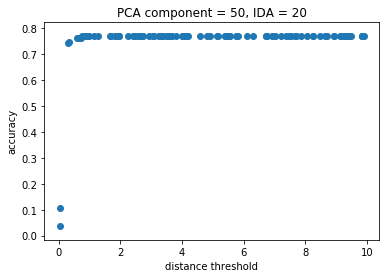

In [26]:
plt.title("PCA component = 50, IDA = 20")
plt.ylabel('accuracy')
plt.xlabel('distance threshold')
plt.scatter(thres_history, acc_history)
plt.show()

## To get the best hyper-parameters

0.20822919777319537 0.2875816993464052


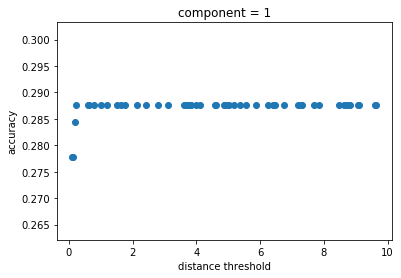

0.8123785059234445 0.696078431372549


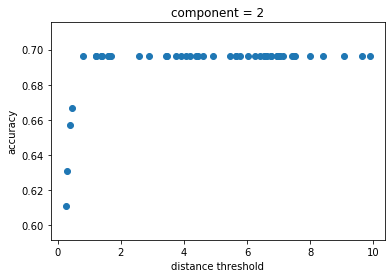

2.0126522959284507 0.7581699346405228


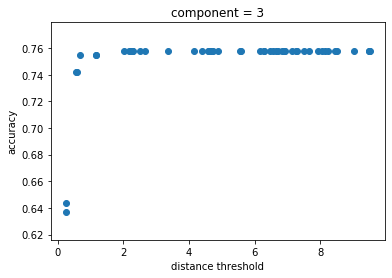

1.667408827847222 0.761437908496732


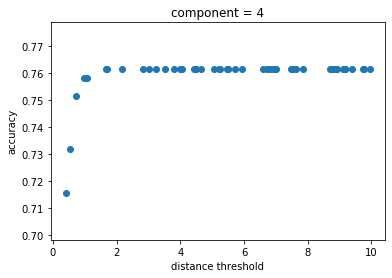

2.4380676176670333 0.7647058823529411


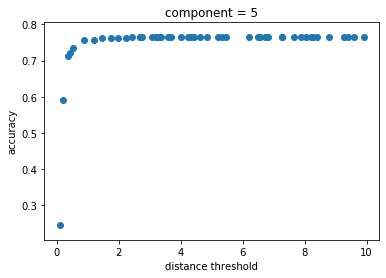

2.0540389806200556 0.7647058823529411


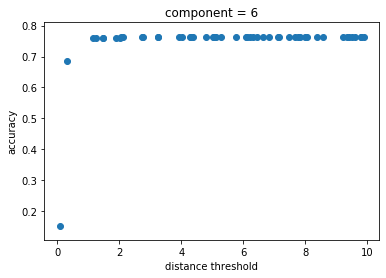

1.848440222553046 0.7679738562091504


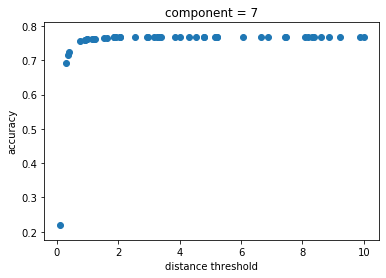

2.104522505274958 0.7679738562091504


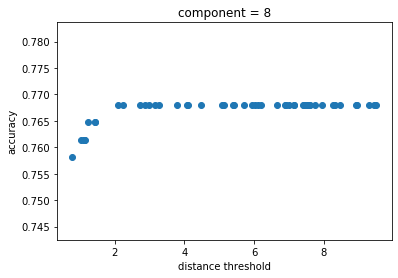

1.5804497128468065 0.7679738562091504


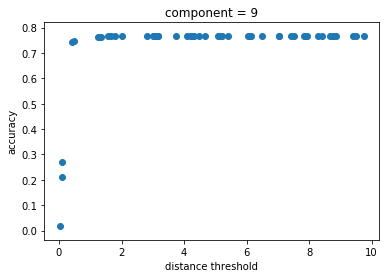

1.4785760727823627 0.7679738562091504


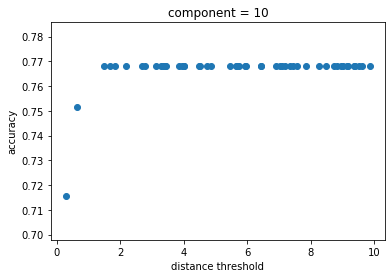

1.2911676535050487 0.7679738562091504


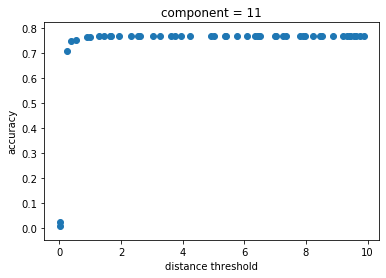

1.1233717793397668 0.7679738562091504


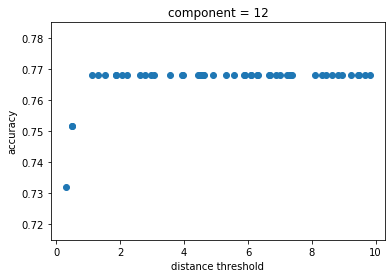

1.0707490225268046 0.7712418300653595


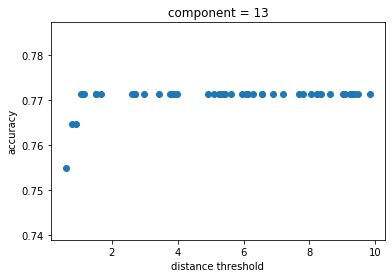

0.957268850332601 0.7712418300653595


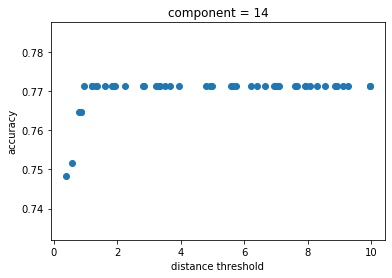

1.0205538310373086 0.7712418300653595


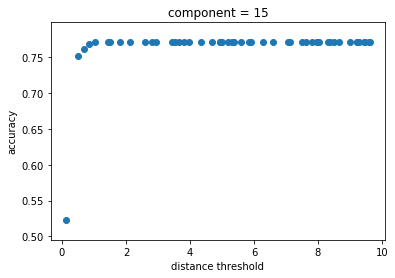

0.9551473875690175 0.7712418300653595


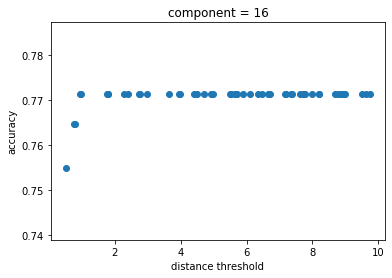

0.9810070455690301 0.7712418300653595


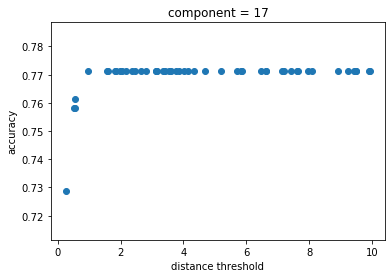

0.776787679134523 0.7712418300653595


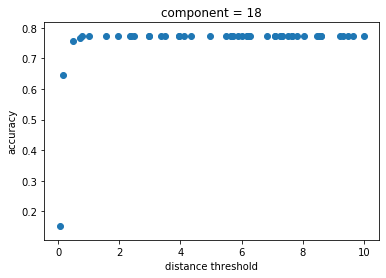

0.7497926119069287 0.7712418300653595


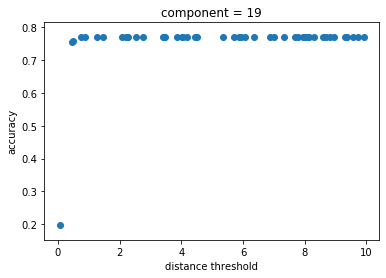

0.7379248045949749 0.7712418300653595


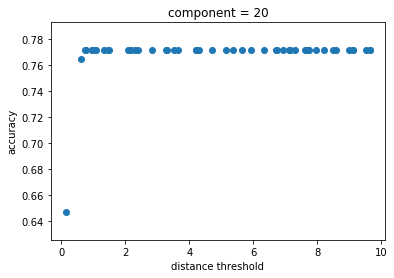

0.773909798249699 0.7712418300653595


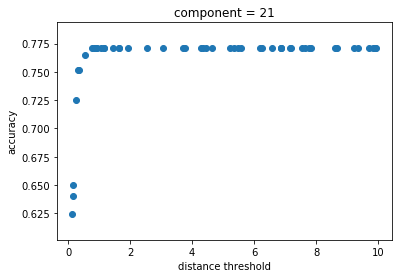

0.646080119861413 0.7712418300653595


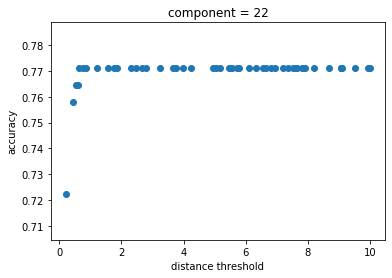

0.7056734147295851 0.7712418300653595


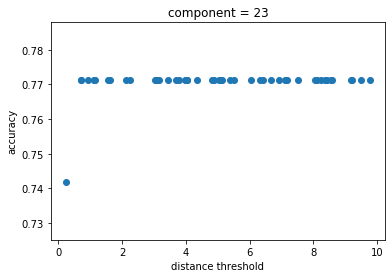

0.619827425788736 0.7712418300653595


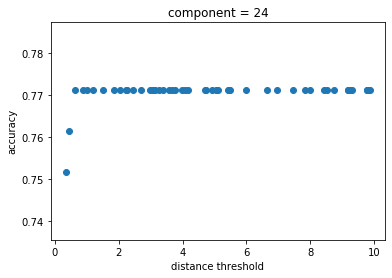

0.9311745032601704 0.7712418300653595


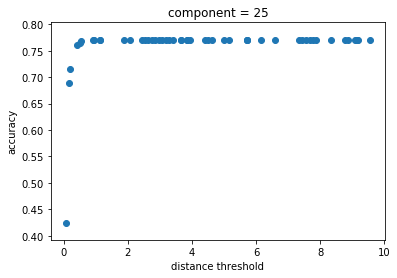

0.5927895765791502 0.7712418300653595


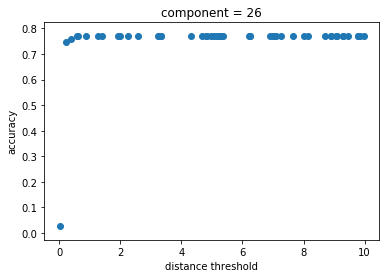

0.6401646844310227 0.7712418300653595


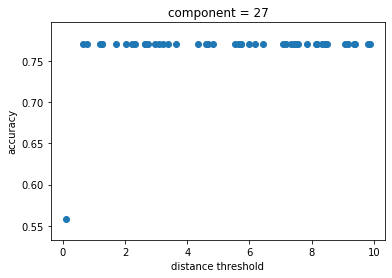

0.7329893906722462 0.7712418300653595


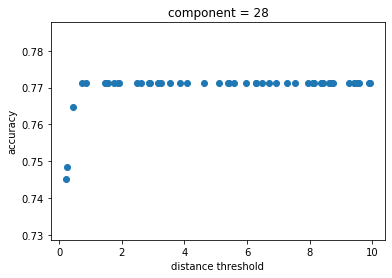

0.6546180331720675 0.7712418300653595


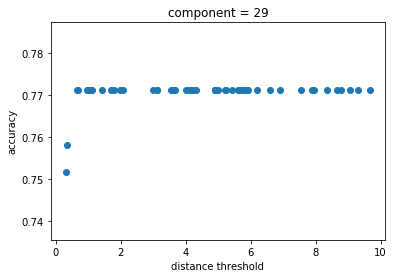

In [51]:
lda_component_acc_tuple = []
for i in range(1, 30):
    x_train_new, x_test_new = train(30, i)

    ran_arr = np.random.rand(50)*10
    
    best_thres = 0
    max_acc = 0

    thres_history = []
    acc_history = []

    for thres in np.sort(ran_arr):
        result = predict(x_train_new, x_test_new, thres)
        accuracy = acc(result, y_test)

        thres_history.append(thres)
        acc_history.append(accuracy)

        if accuracy > max_acc:
            max_acc = accuracy
            best_thres = thres

    print(best_thres, max_acc)
    lda_component_acc_tuple.append((i, max_acc))
    
    plt.title("component = %d"%i)
    plt.ylabel('accuracy')
    plt.xlabel('distance threshold')
    plt.scatter(thres_history, acc_history)
    plt.show()

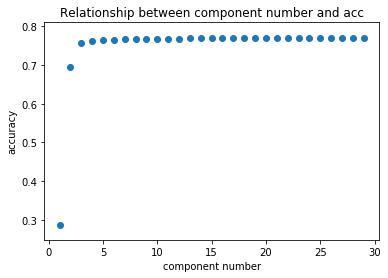

In [52]:
plt.title("Relationship between component number and acc")
plt.ylabel('accuracy')
plt.xlabel('component number')
plt.scatter([i for i, _ in lda_component_acc_tuple], [acc for _, acc in lda_component_acc_tuple])
plt.show()

In [53]:
best_acc = 0
index = 0
for i, acc in lda_component_acc_tuple:
    if acc > best_acc:
        index = i
        best_acc = acc
print(index, best_acc)

13 0.7712418300653595


In [54]:
import time
start = time.time()
result = predict(x_train_new, x_test_new, thres)
end = time.time()
print("prediction time of close test face, ", end-start)
print('prediction time per face is: ', (end - start)/ len(x_test_new))

prediction time of close test face,  2.5433971881866455
prediction time per face is:  0.008311755516949822
